In [ ]:
!pip install opencv-python-headless


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import time
import io

# Function to access the webcam and automatically capture an image
def take_photo_auto(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Automatically capture without button click
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            video.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)

    # Capture the image as a base64 encoded string
    data = eval_js('takePhoto({})'.format(quality))
    # Decode the base64 encoded string
    binary = b64decode(data.split(',')[1])
    # Save the image to file
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Function to capture images automatically at intervals
def auto_capture_images(interval=10, num_captures=5):
    for i in range(num_captures):
        filename = f"photo_{i+1}.jpg"  # Unique filename for each capture
        filename = take_photo_auto(filename=filename)
        print(f'Saved to {filename}')
        time.sleep(interval)  # Wait for the specified interval

# Automatically capture an image every 10 seconds, for a total of 5 captures
auto_capture_images(interval=10, num_captures=5)



<IPython.core.display.Javascript object>

Saved to photo_1.jpg


<IPython.core.display.Javascript object>

Saved to photo_2.jpg


<IPython.core.display.Javascript object>

Saved to photo_3.jpg


<IPython.core.display.Javascript object>

Saved to photo_4.jpg


<IPython.core.display.Javascript object>

Saved to photo_5.jpg


In [ ]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio

# Load model and processor
processor = WhisperProcessor.from_pretrained("openai/whisper-small")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")
model.config.forced_decoder_ids = None

# Load your own audio file
file_path = "/content/WhatsApp Audio 2024-11-11 at 12.48.56 PM.mpeg"
audio_waveform, sample_rate = torchaudio.load(file_path)

# Make sure the sampling rate matches Whisper's expected rate
if sample_rate != 16000:
    audio_waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(audio_waveform)
    sample_rate = 16000

# Process audio
input_features = processor(audio_waveform.squeeze().numpy(), sampling_rate=sample_rate, return_tensors="pt").input_features

# Generate token ids
predicted_ids = model.generate(input_features)

# Decode token ids to text
transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)
print("Transcription:", transcription[0])


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Transcription:  What can you see in this image?


# Running Llava: a large multi-modal model on Google Colab

In [ ]:
!pip install -q transformers==4.41.0
# Install compatible versions of the packages
!pip install transformers==4.41.0 bitsandbytes==0.41.3 accelerate==0.26.0 sentence-transformers
# Uninstall sentence-transformers if not needed
!pip uninstall -y sentence-transformers

# Then install the required package versions
!pip install transformers==4.37.2 bitsandbytes==0.41.3 accelerate==0.25.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.7/270.7 kB 20.6 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.2.1
    Uninstalling accelerate-1.2.1:
      Successfully uninstalled accelerate-1.2.1


Found existing installation: sentence-transformers 3.3.1
Uninstalling sentence-transformers-3.3.1:
  Successfully uninstalled sentence-transformers-3.3.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 97.1 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [ ]:
# Create virtual environment (you only need to do this once)
!python -m venv myenv

# Activate the environment
!source myenv/bin/activate  # On Linux/MacOS
# or
!myenv\Scripts\activate  # On Windows

# Install required packages
!pip install transformers==4.37.2 bitsandbytes==0.41.3 accelerate==0.25.0


The virtual environment was not created successfully because ensurepip is not
available.  On Debian/Ubuntu systems, you need to install the python3-venv
package using the following command.

    apt install python3.10-venv

You may need to use sudo with that command.  After installing the python3-venv
package, recreate your virtual environment.

Failing command: /content/myenv/bin/python3

/bin/bash: line 1: myenv/bin/activate: No such file or directory
/bin/bash: line 1: myenvScriptsactivate: command not found
  Using cached transformers-4.37.2-py3-none-any.whl.metadata (129 kB)
  Using cached accelerate-0.25.0-py3-none-any.whl.metadata (18 kB)
  Using cached tokenizers-0.15.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached transformers-4.37.2-py3-none-any.whl (8.4 MB)
Using cached accelerate-0.25.0-py3-none-any.whl (265 kB)
Using cached tokenizers-0.15.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Attempting uninstal

## Load an image

Let's use the image that has been used for Llava demo

And ask the model to describe that image!

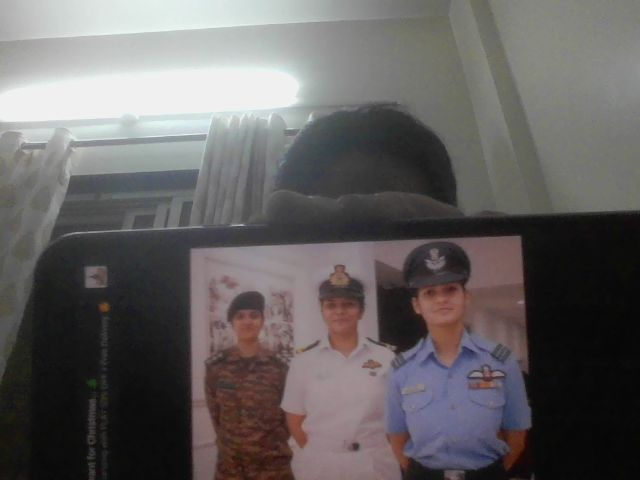

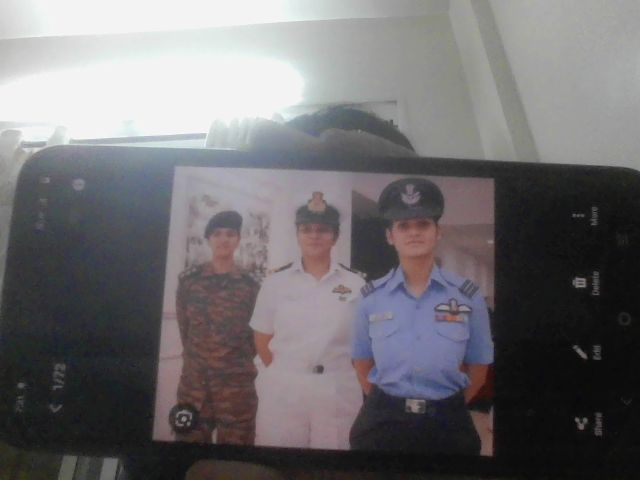

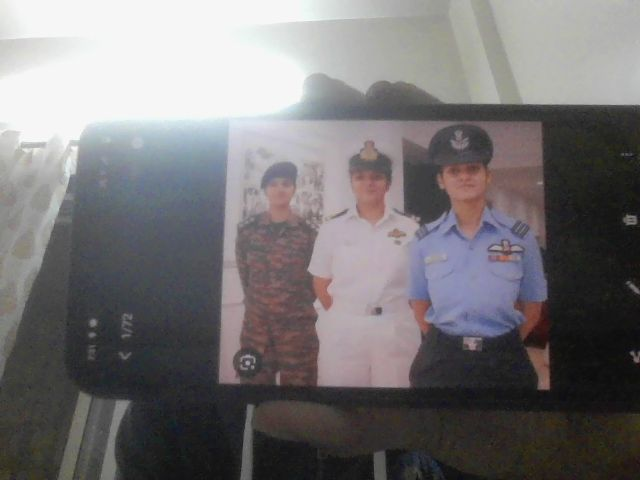

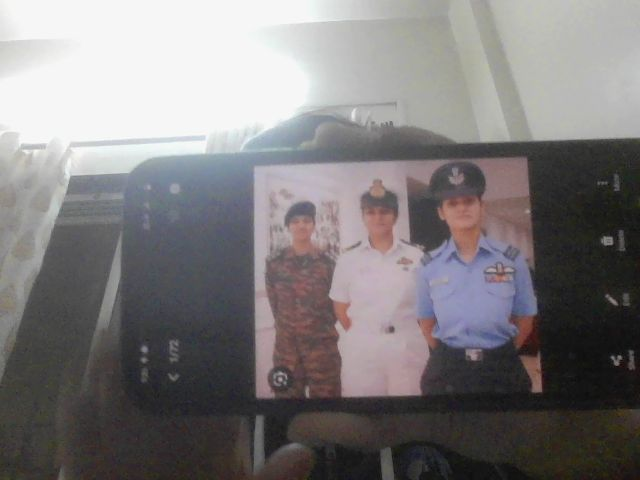

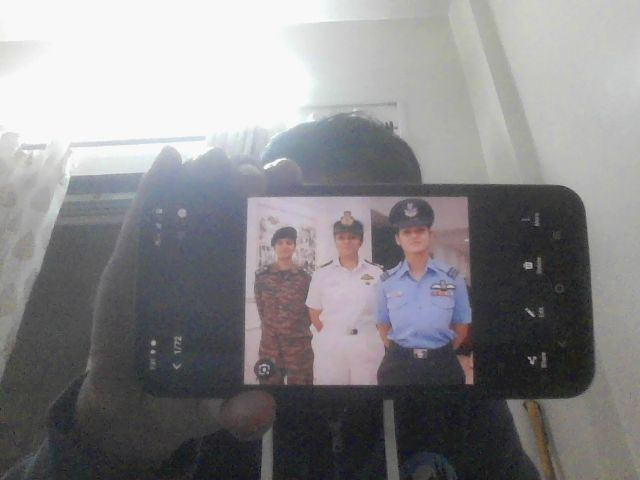

In [ ]:
from PIL import Image

# Loop to load and display each captured image
for i in range(1, 6):  # Adjust the range if you have more images
    image_path = f"/content/photo_{i}.jpg"  # Adjust the path if needed
    image = Image.open(image_path).convert('RGB')
    display(image)  # Display each image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preparing the quantization config to load the model in 4bit precision

In order to load the model in 4-bit precision, we need to pass a `quantization_config` to our model. Let's do that in the cells below

In [ ]:
import torch
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_16bit=True,  # Set this to 16-bit instead of 4-bit or 8-bit
    bnb_16bit_compute_dtype=torch.float16  # Use torch.float16 or another appropriate dtype
)


Unused kwargs: ['load_in_16bit', 'bnb_16bit_compute_dtype']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


## Load the model using `pipeline`

We will leverage the `image-to-text` pipeline from transformers !

In [ ]:
!pip install accelerate>=0.26.0

!pip install --upgrade transformers


!pip install --upgrade transformers accelerate bitsandbytes
import transformers
import accelerate
import bitsandbytes

print("Transformers version:", transformers.__version__)
print("Accelerate version:", accelerate.__version__)
import bitsandbytes as bnb # This line was incorrectly indented
print("BitsAndBytes is installed and available!")
#The try-except block to check for bitsandbytes is removed since it's redundant after importing it.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 96.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.37.2
    Uninstalling transformers-4.37.2:
      Successfully uninstalled transformers-4.37.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 69.1/69.1 MB 138.4 MB/s eta 0:00:01
ERROR: Operation cancelled by user
Transformers version: 4.37.2
Accelerate version: 0.25.0
BitsAndBytes is installed and available!


In [ ]:
!pip show transformers accelerate bitsandbytes


Name: transformers
Version: 4.47.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft
---
Name: accelerate
Version: 0.25.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: sylvain@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: peft
---
Name: bitsandbytes
Version: 0.41.3
Summary: k-bit optimizers and matrix multiplication rout

In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("PyTorch version:", torch.__version__)


CUDA available: True
CUDA version: 12.1
PyTorch version: 2.5.1+cu121


In [ ]:
!pip show transformers accelerate bitsandbytes
import transformers
import accelerate
import bitsandbytes

print("Transformers version:", transformers.__version__)
print("Accelerate version:", accelerate.__version__)


Name: transformers
Version: 4.47.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft
---
Name: accelerate
Version: 1.2.1
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: peft
---
Name: bitsandbytes
Version: 0.41.3
Summary: k-bit optimizers and matrix multiplication 

In [ ]:
!pip install accelerate==0.26.0  # Replace with desired version

  Using cached accelerate-0.26.0-py3-none-any.whl.metadata (18 kB)
Using cached accelerate-0.26.0-py3-none-any.whl (270 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.2.1
    Uninstalling accelerate-1.2.1:
      Successfully uninstalled accelerate-1.2.1


In [ ]:
!pip install -U accelerate

In [ ]:
import accelerate
from transformers import pipeline

model_id = "llava-hf/llava-1.5-7b-hf"

pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Device set to use cuda:0


It is important to prompt the model wth a specific format, which is:
```bash
USER: <image>\n<prompt>\nASSISTANT:
```

In [ ]:
max_new_tokens =500
prompt = f"USER: <image>\n{transcription}\nASSISTANT:"
outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})


Passing `prompt` to the `image-to-text` pipeline is deprecated and will be removed in version 4.48 of 🤗 Transformers. Use the `image-text-to-text` pipeline instead
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:451: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.


In [ ]:
print(outputs[0]["generated_text"])

USER:  
[' What can you see in this image?', ' What can you see in this image?']
ASSISTANT: In the image, there are three people standing next to each other. They appear to be dressed in military uniforms, and they are all looking at the camera. The photo is taken with a cell phone, which is held up to capture the moment. The three individuals are the main focus of the image, and their presence in the scene suggests that they might be part of a military unit or participating in a special event.


The model has managed to successfully describe the image with accurate result ! We also support other variants of Llava, such as [`bakLlava`](https://huggingface.co/llava-hf/bakLlava-v1-hf) which should be all posted inside the [`llava-hf`](https://huggingface.co/llava-hf) organization on 🤗 Hub